In [ ]:
!git clone https://github.com/Helene-Maxcici/protein_stability_prediction.git

fatal: destination path 'protein_stability_prediction' already exists and is not an empty directory.


In [ ]:
!pip install -r protein_stability_prediction/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import zipfile

from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import random
import seaborn as sns
from scipy.special import softmax


import torch
from transformers import BertTokenizer, BertModel, BertConfig
from torchmetrics import SpearmanCorrCoef

from protein_stability_prediction.enzyme_dataset import (group_mutations, 
                                locate_mutations, split_group, 
                                 split_tm, truncate_sequence, group_mutations,
                                 Dataset, DatasetPairs, get_number_AA)

from protein_stability_prediction.enzyme_model import Bert_MLPHead, Trainer

In [ ]:
# Set of possible Amino-Acids
AA_letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# Fixing seeds
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


## Load Data

In [ ]:
## Load data
# Load zipped Data
!gdown 1b-cIT6gTV5IVguTYQoiX1MPQ0sbRF0ej
# Unzip
with zipfile.ZipFile("/content/novozymes_data.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")
# Load sets
df_full = pd.read_csv("/content/train.csv")
df_submission = pd.read_csv("/content/test.csv")

print("Size of Full set: ", len(df_full))
print("Size of Submission set: ", len(df_submission))

Downloading...
From: https://drive.google.com/uc?id=1b-cIT6gTV5IVguTYQoiX1MPQ0sbRF0ej
To: /content/novozymes_data.zip
100% 7.41M/7.41M [00:00<00:00, 178MB/s]
Size of Full set:  31390
Size of Submission set:  2413


In [ ]:
df_updates = pd.read_csv("/content/train_updates_20220929.csv").set_index("seq_id")

# Remove bad sequences
nan_seq = df_updates['protein_sequence'].isna()
df_full.drop(df_updates[nan_seq].index, inplace = True)
# Swap pH and tm
swap_ids = df_updates.loc[~nan_seq].index
df_full.loc[swap_ids,["pH","tm"]] = df_updates.loc[~nan_seq,["pH","tm"]]

# Remove sequences with no pH
df_full.dropna(subset = ['pH'], inplace = True)
# Remove all duplicates
df_full.drop_duplicates(subset = ["protein_sequence", "pH"], 
                        inplace = True)
print("Final size: ", len(df_full))

Final size:  27875


## Preprocessing

In [ ]:
# Compute length per sequence
df_full["len"] = df_full["protein_sequence"].apply(len)

# Count amino acids per sequence
df_count = pd.DataFrame(columns = AA_letters)

# Loop over amino-acids
for aa in AA_letters:
  df_count[aa] = df_full["protein_sequence"].str.count(aa)

# Find mutations
#s_groups = group_mutations(df_full, max_rate = 0.34)
#s_groups.to_csv("/content/substitution_groups.csv")

# Load precomputed mutation groups
!gdown 1PCF7M6wFoSIAjc5y0IV64Y5tgYKzpyyO

s_groups = pd.read_csv("/content/substitution_groups.csv", header = 0,  
                       names = ["sub_group"], index_col = 0, squeeze = True)

# Set groups
df_full["sub_group"] = s_groups

# Locate mutations 
s_locations = locate_mutations(df_full)
# Set locations
df_full.loc[s_locations.keys(), "sub_locations"] = s_locations

Downloading...
From: https://drive.google.com/uc?id=1PCF7M6wFoSIAjc5y0IV64Y5tgYKzpyyO
To: /content/substitution_groups.csv
100% 206k/206k [00:00<00:00, 108MB/s]


In [ ]:
# Number of samples belong to groups 
perc = len(df_full[~df_full["sub_group"].isna()]) / len(df_full)
print(f"Percentage of proteins belonging to groups of mutation is only: {100*perc:.2f}%")

Percentage of proteins belonging to groups of mutation is only: 15.25%


## Split Dataset

In [ ]:
df_full["split"] = np.nan
# Split groups (The splits are deterministic by fixing the random seed)
df_full = split_group(df_full, 0.15, 0.15)
print(df_full.split.value_counts(normalize = "true"))
# Split individual proteins 
df_full = split_tm(df_full, 0.15, 0.15, mask = df_full["split"].isna())
print(df_full.split.value_counts(normalize = "true"))


train    0.750941
test     0.142051
val      0.107008
Name: split, dtype: float64
train    0.707874
test     0.148807
val      0.143318
Name: split, dtype: float64


In [ ]:
df_train = df_full[df_full["split"] == "train"].copy(deep =True)
df_val = df_full[df_full["split"] == "val"].copy(deep =True)
df_test = df_full[df_full["split"] == "test"].copy(deep =True)

print("Train size: ", len(df_train))
print("Validation size: ", len(df_val))
print("Test size: ", len(df_test))

Train size:  19732
Validation size:  3995
Test size:  4148


In [ ]:
# Checking distribution of mutations 
perc = 1 - df_train["sub_group"].isna().sum() / len(df_train)
print(f"Train: {100*perc:.2f}%")
perc = 1 - df_val["sub_group"].isna().sum() / len(df_val)
print(f"Val: {100*perc:.2f}%")
perc = 1 - df_test["sub_group"].isna().sum() / len(df_test)
print(f"Test: {100*perc:.2f}%")

Train: 16.18%
Val: 11.39%
Test: 14.56%


#### Test the truncate function

In [ ]:
test_seq = "".join(["A"]*6 + ["B"]*5 + ["C"]*3 + ["D"]*5)
test_seq_mut = list(test_seq)
diff_loc_test = [2, 10, len(test_seq_mut)-1]
test_seq_mut[diff_loc_test[0]] = "U"
test_seq_mut[diff_loc_test[1]] = "V"
test_seq_mut[diff_loc_test[2]] = "W"
test_seq_mut = "".join(test_seq_mut)

print(f"Test Sequence: {test_seq}")
print(f"Test Sequence Mutation: {test_seq_mut}")

settings_test = {"max_length" : 4, 
                "truncate" : "single", 
                "overlap" : 0, 
                "sample_splits" : None}  

# Settings 1: single
test_trunc = []
for i in range(3):
  test_trunc.append(truncate_sequence(test_seq, 
                                      settings_test)[0])
print(f"Output 1 - Single:\n{test_trunc}")
len_test = get_number_AA(test_seq, settings_test)
print(len(test_trunc[0][0]), len_test)

# Settings 2: single + position preference
test_trunc = []
for i in range(10):
  test_trunc.append(truncate_sequence(test_seq_mut, settings_test, 
                                      diff_loc_test)[0])
print(f"Output 2 - Single + Pref:\n{test_trunc}")
len_test = get_number_AA(test_seq, settings_test)
print(len(test_trunc[0][0]), len_test)

# Settings 3: split
settings_test["truncate"] = "split"
test_trunc, aa_positions_ids = truncate_sequence(test_seq, settings_test)
print(f"Output 3 - Split:\n{test_trunc}")
len_test = get_number_AA(test_seq, settings_test)
print(len("".join(test_trunc)), len_test)

# Settings 4: split + overlap
settings_test["overlap"] = 0.4
test_trunc, aa_positions_ids = truncate_sequence(test_seq, settings_test)
print(f"Output 4 - Split + Overlap:\n{test_trunc}")
print(f"Mask_ends: {aa_positions_ids}")
len_test = get_number_AA(test_seq, settings_test)
print(len("".join(test_trunc)), len_test)

# Settings 5: split + sample
settings_test["overlap"] = 0.4
settings_test["sample_splits"] = 3
test_trunc = []
for i in range(5):
  test_trunc.append(truncate_sequence(test_seq_mut, 
                                      settings_test))
print(f"Output 5 - Split + Sample:\n{test_trunc}")
len_test = get_number_AA(test_seq, settings_test)
print(len("".join(test_trunc[0][0])), len_test)

# Serring 6: split + sample + pref
T = 2
test_trunc = []
for i in range(3):
  test_trunc.append(truncate_sequence(test_seq_mut, settings_test, 
                                      diff_loc_test, T))
print(f"Output 5 - Split + Sample + pref:\n{test_trunc}")
len_test = get_number_AA(test_seq, settings_test)
print(len("".join(test_trunc[0][0])), len_test)

Test Sequence: AAAAAABBBBBCCCDDDDD
Test Sequence Mutation: AAUAAABBBBVCCCDDDDW
Output 1 - Single:
[['CCCD'], ['ABBB'], ['BBBB']]
4 4
Output 2 - Single + Pref:
[['CCDD'], ['DDDW'], ['AAUA'], ['BBBV'], ['DDW'], ['AAUA'], ['CCCD'], ['W'], ['UAAA'], ['AAUA']]
4 4
Output 3 - Split:
['XAAA', 'AAAB', 'BBBB', 'CCCD', 'DDDD', 'X']
21 20
Output 4 - Split + Overlap:
['XAAA', 'AAAA', 'AAAB', 'ABBB', 'BBBB', 'BBCC', 'CCCD', 'CDDD', 'DDDD', 'DDX']
Mask_ends: [array([0, 1, 2, 3]), array([2, 3, 4, 5]), array([4, 5, 6, 7]), array([6, 7, 8, 9]), array([ 8,  9, 10, 11]), array([10, 11, 12, 13]), array([12, 13, 14, 15]), array([14, 15, 16, 17]), array([16, 17, 18, 19]), array([18, 19, 20])]
39 36
Output 5 - Split + Sample:
[(['BVCC', 'AAAB', 'AUAA'], [array([10, 11, 12, 13]), array([4, 5, 6, 7]), array([2, 3, 4, 5])]), (['DWX', 'BBBV', 'CCCD'], [array([18, 19, 20]), array([ 8,  9, 10, 11]), array([12, 13, 14, 15])]), (['BVCC', 'DWX', 'AAAB'], [array([10, 11, 12, 13]), array([18, 19, 20]), array([4, 5, 6, 

## Train

In [ ]:
settings_train = {"max_length" : 128, 
                  "truncate" : "split", 
                  "overlap" : 0.05, 
                  "sample_splits" : 8}
                  
settings_val = {"max_length" : 128, 
                "truncate" : "split", 
                "overlap" : 0.05, 
                "sample_splits" : None}


In [ ]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", 
                                          do_lower_case=False, 
                                          model_input_names = ['input_ids',
                                                               'attention_mask'])

In [ ]:
dataset_train = Dataset(df_train, tokenizer = tokenizer, 
                        settings = settings_train)
dataset_val = Dataset(df_val, tokenizer = tokenizer, 
                      settings = settings_val)
dataset_test = Dataset(df_test, tokenizer = tokenizer,
                       settings = settings_val)

datasetpairs_train = DatasetPairs(df_train[~df_train["sub_group"].isna()], 
                                tokenizer = tokenizer, 
                                settings = {"max_length" : 128, 
                                            "truncate" : "split", 
                                            "overlap" : 0.05, 
                                            "sample_splits" : 8})

bert_mlphead = Bert_MLPHead("Rostlab/prot_bert", add_bert_pooler = False,
                            linear_layers = [0.5], include_ph = True, 
                            fusion = "weighted")

# Two choices of parameters
# MSE loss
criterion_reg = torch.nn.MSELoss()
# MARGINRANK loss
criterion_rank = torch.nn.MarginRankingLoss(margin = 5)
# Spearman's correlation
spearman = SpearmanCorrCoef()
# Optimizer
lr = 1e-5
optimizer = torch.optim.Adam(bert_mlphead.parameters(), lr = lr)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.

In [ ]:
# Instanciate the trainer
trainer = Trainer(model = bert_mlphead,
                  device = "cuda:0")

trainer.set_optimization(criterion_reg = criterion_reg, criterion_rank= criterion_rank, 
                         optimizer = optimizer, 
                         metric = spearman)

# Freeze layers

trainer.model.freeze_bert()
trainer.model.unfreeze_encoderlayers(layers = [-1])

device: cuda:0


In [ ]:
trainer.fit(dataset_train = dataset_train, 
            datasetpairs_train = datasetpairs_train, 
            dataset_val = dataset_val, 
            settings_train = settings_train,
            settings_val = settings_val,
            train_rank = False, n_rank_step = 0,
            n_epochs = 3, batch_size = 256 * settings_train["max_length"], 
            n_logs = 5 ,num_workers = 4, pin_memory = True,
            debug = False, mixed_precision = True)

 25%|██▌       | 74/292 [03:16<09:57,  2.74s/it]


<TRAIN> Epoch: 0     - Batch: 73   | Loss_reg: 2695.258  SCC: -3.478   


 50%|█████     | 147/292 [06:34<06:38,  2.75s/it]


<TRAIN> Epoch: 0     - Batch: 146  | Loss_reg: 2443.516  SCC: -0.652   


 75%|███████▌  | 220/292 [09:51<03:18,  2.75s/it]


<TRAIN> Epoch: 0     - Batch: 219  | Loss_reg: 2133.503  SCC: 0.455    


100%|██████████| 136/136 [08:05<00:00,  3.57s/it]
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
100%|██████████| 46/46 [02:41<00:00,  3.52s/it]



<TRAIN> Epoch: 0     |Loss_reg: 1774.913   Loss_rank: 4.991      SCC: 0.713   Mut-Avg Scc: -3.393  
<VALID> Epoch: 0     |Loss_reg: 1681.588   Loss_rank: 5.006      SCC: -1.560  Mut-Avg Scc: -5.558  



 25%|██▌       | 74/292 [03:20<10:02,  2.77s/it]


<TRAIN> Epoch: 1     - Batch: 73   | Loss_reg: 1707.186  SCC: -0.541   


 50%|█████     | 147/292 [06:37<06:32,  2.71s/it]


<TRAIN> Epoch: 1     - Batch: 146  | Loss_reg: 1373.474  SCC: -1.685   


 75%|███████▌  | 220/292 [09:54<03:16,  2.73s/it]


<TRAIN> Epoch: 1     - Batch: 219  | Loss_reg: 1115.129  SCC: -0.434   


100%|██████████| 46/46 [02:41<00:00,  3.52s/it]



<TRAIN> Epoch: 1     |Loss_reg: 836.138    Loss_rank: 4.950      SCC: 0.240   Mut-Avg Scc: 3.763   
<VALID> Epoch: 1     |Loss_reg: 780.985    Loss_rank: 5.014      SCC: -5.370  Mut-Avg Scc: -31.684 



 25%|██▌       | 74/292 [03:19<09:54,  2.73s/it]


<TRAIN> Epoch: 2     - Batch: 73   | Loss_reg: 818.432   SCC: 0.472    


 50%|█████     | 147/292 [06:36<06:35,  2.73s/it]


<TRAIN> Epoch: 2     - Batch: 146  | Loss_reg: 571.472   SCC: 0.469    


 75%|███████▌  | 220/292 [09:52<03:16,  2.73s/it]


<TRAIN> Epoch: 2     - Batch: 219  | Loss_reg: 447.661   SCC: 4.257    


100%|██████████| 46/46 [02:41<00:00,  3.51s/it]



<TRAIN> Epoch: 2     |Loss_reg: 317.187    Loss_rank: 4.849      SCC: 4.089   Mut-Avg Scc: 1.699   
<VALID> Epoch: 2     |Loss_reg: 288.299    Loss_rank: 5.021      SCC: -6.842  Mut-Avg Scc: -47.076 



## Show curves

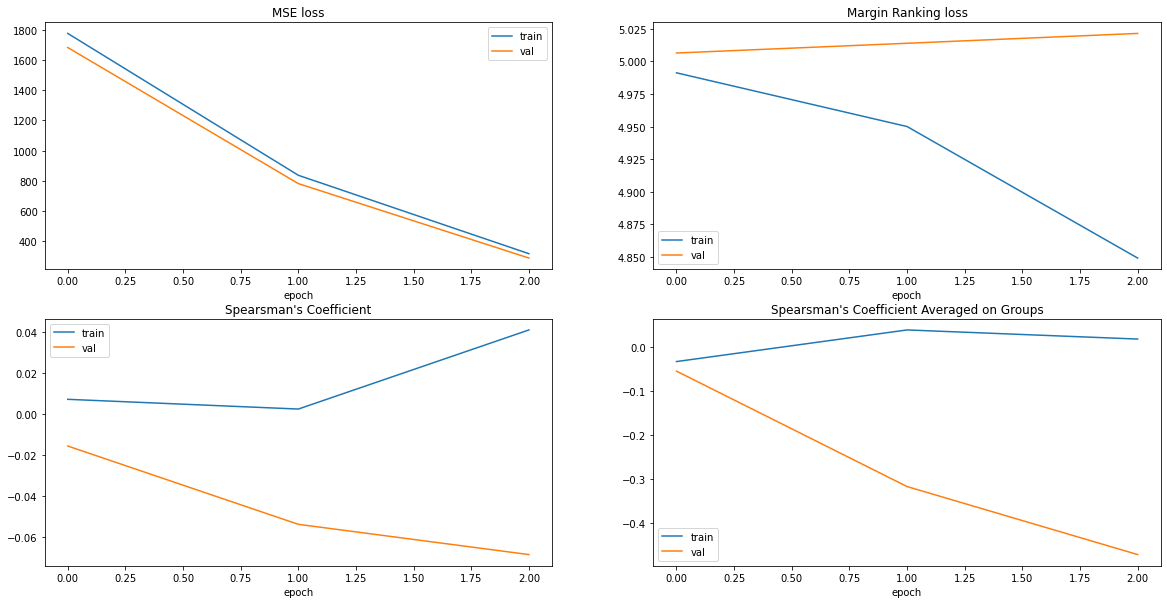

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(20, 10))

axes[0,0].plot(trainer.out_train["Loss_reg"], label = "train")
axes[0,0].plot(trainer.out_val["Loss_reg"], label = "val")
axes[0,0].set_title("MSE loss");
axes[0,0].set_xlabel("epoch");
axes[0,0].legend()

axes[0,1].plot(trainer.out_train["Loss_rank"], label = "train")
axes[0,1].plot(trainer.out_val["Loss_rank"], label = "val")
axes[0,1].set_title("Margin Ranking loss");
axes[0,1].set_xlabel("epoch");
axes[0,1].legend()

axes[1,0].plot(trainer.out_train["SCC"], label = "train")
axes[1,0].plot(trainer.out_val["SCC"], label = "val")
axes[1,0].set_title("Spearsman's Coefficient");
axes[1,0].set_xlabel("epoch");
axes[1,0].legend()

axes[1,1].plot(trainer.out_train["SCC_mut_avg"], label = "train")
axes[1,1].plot(trainer.out_val["SCC_mut_avg"], label = "val")
axes[1,1].set_title("Spearsman's Coefficient Averaged on Groups");
axes[1,1].set_xlabel("epoch");
axes[1,1].legend()